In [32]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, plot_roc_curve

- Submission_1 : Single XGB with random state 0 with SMOTE
- Submission_2 : Combination of 5 XGB and 5 Random Forest with Random state 0 with SMOTE
- Submission_3 : Combination of 5 Random Forest with Random state 0 with SMOTE

In [3]:
train = pd.read_csv('TrainingData.csv')
test = pd.read_csv('testX.csv')

df = pd.concat([train, test], axis = 0)

df.shape

/tmp/ipykernel_89736/1837120322.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('TrainingData.csv')
/tmp/ipykernel_89736/1837120322.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv('testX.csv')


(130000, 53)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130000 entries, 0 to 46999
Data columns (total 53 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   application_key  130000 non-null  int64  
 1   mvar1            130000 non-null  object 
 2   mvar2            120787 non-null  float64
 3   mvar3            129171 non-null  float64
 4   mvar4            129171 non-null  float64
 5   mvar5            129171 non-null  float64
 6   mvar6            130000 non-null  object 
 7   mvar7            130000 non-null  object 
 8   mvar8            130000 non-null  object 
 9   mvar9            130000 non-null  object 
 10  mvar10           130000 non-null  object 
 11  mvar11           130000 non-null  object 
 12  mvar12           130000 non-null  object 
 13  mvar13           130000 non-null  object 
 14  mvar14           130000 non-null  int64  
 15  mvar15           130000 non-null  object 
 16  mvar16           130000 non-null  objec

In [5]:
columns = ['ID',
           'Credit Worthiness Score',
           'Number and Riskiness of Credit Enquiry',
           'Default Severity (Any Loan)',
           'Default Severity (Auto Loan)',
           'Default Severity (Education Loan)',
           'Min Cred Available (Revolving Credit Cards)',
           'Max Cred Available (Active Credit Lines)',
           'Max Cred Available (Active Revolving Credit Cards)',
           'Total Available Credit (Cards with 1 missed payment)',
           'Total Credit Available',
           'Dues Collected Post Default',
           'Total Amount Due (Active Cards)',
           'Credit Amount Paid (Prev Year)',
           'Annual Income',
           'Property Value',
           'Full Credit Utilisation (Revolving Credit Cards)',
           'Full Credit Utilisation (Credit Cards)',
           'Full Credit Utilisation (Credit Lines)',
           '>75 percent Credit Utilisation (Credit Cards)',
           '>75 percent Credit Utilisation (Credit Lines)',
           'Average Utilisation (Revolving Credit Cards)',
           'Average Utilisation Last 2 Years (All Credit Lines)',
           'Average Utilisation Last Year (All Credit Cards)',
           'Average Utilisation Last 6 Months with 1 Missed Payment (Credit Cards)',
           'Average Tenure (Active Revolving Credit Cards)',
           'Tenure of Oldest Active Credit Card',
           'Tenure of Oldest Active Revolving Credit Card',
           'Days Since Last Missed Payment',
           'Tenure of Oldest Credit Line',
           'Max Tenure (Auto Loans)',
           'Max Tenure (Education Loans)',
           'Sum of Tenures (Active Credit Cards)',
           'Stay Duration of Current Residence',
           'Credit Lines with 1 Missed Payment (Last 6 Months)',
           'Revolving Credit Cards with 1 Missed Payment (Last 2 Years)',
           'Active Credit Lines',
           'Credit Cards with >2Y Tenure',
           'Credit Lines activated Prev 2 Years',
           'Credit Lines with Current Delinquency',
           'Utilization on Active Education Loans',
           'Utilization on Active Auto Loans',
           'Financial Stress Index',
           'Credit Lines with No Missed Payments (Prev 2 Years)',
           'Ratio(Max Amount Due : Sum of Amounts Due)',
           'Mortgage Loans (With 2 Missed Payements)',
           'Auto Loans (With 2 Missed Payments)',
           'Type of Product',
           'Int Value for an Application',
           'Bucketized Credit Worthiness Score',
           'Compound of mvar49 and mvar48',
           'mvar51',
           'default_ind']

In [6]:
df.columns = columns

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130000 entries, 0 to 46999
Data columns (total 53 columns):
 #   Column                                                                  Non-Null Count   Dtype  
---  ------                                                                  --------------   -----  
 0   ID                                                                      130000 non-null  int64  
 1   Credit Worthiness Score                                                 130000 non-null  object 
 2   Number and Riskiness of Credit Enquiry                                  120787 non-null  float64
 3   Default Severity (Any Loan)                                             129171 non-null  float64
 4   Default Severity (Auto Loan)                                            129171 non-null  float64
 5   Default Severity (Education Loan)                                       129171 non-null  float64
 6   Min Cred Available (Revolving Credit Cards)                          

### Feature Understanding (Explanations and Stuff to Look into)

- Auto Loans: Loans where Vehicles are kept as collateral
- Revolving Credit: You have a fixed amount that you can borrow in some fixed time frame. After that the amount you can borrow replenishes to the full amount. Although you will have a maximum limit. For example, you can borrow 100 rupees a month max and the overall limit on that credit line is 500 rupees. So if your overall borrowed amount is 460 rupees and for that month you havenn't borrowed anything so far, you will be able to borrow only 40 rupees even though the monthly limit is 100
- Difference between Credit Worthiness Score and its bucketized version?
- Difference in statistics between train and test (Need for Adverserial Validation?)

### Feature Ideas and Experiments
- Binary Variable for checking if the person has moved into current residence after issuing any credit lines
- Credit Amount Paid / Number of Credit Lines with No Missed Payments
- Max Cred Available vs Default Severity
- Separate modeling for 0 Default Severity vs Non-Zero Default Severity
- KNN Missing Values Fill In
- Property Value vs Annual Income (Some Indicator of whether or not a person spends too much for their Income)
- 75% utilisation / Full Utilisation

In [8]:
df.head(10)

,ID,Credit Worthiness Score,Number and Riskiness of Credit Enquiry,Default Severity (Any Loan),Default Severity (Auto Loan),Default Severity (Education Loan),Min Cred Available (Revolving Credit Cards),Max Cred Available (Active Credit Lines),Max Cred Available (Active Revolving Credit Cards),Total Available Credit (Cards with 1 missed payment),Total Credit Available,Dues Collected Post Default,Total Amount Due (Active Cards),Credit Amount Paid (Prev Year),Annual Income,Property Value,Full Credit Utilisation (Revolving Credit Cards),Full Credit Utilisation (Credit Cards),Full Credit Utilisation (Credit Lines),>75 percent Credit Utilisation (Credit Cards),>75 percent Credit Utilisation (Credit Lines),Average Utilisation (Revolving Credit Cards),Average Utilisation Last 2 Years (All Credit Lines),Average Utilisation Last Year (All Credit Cards),Average Utilisation Last 6 Months with 1 Missed Payment (Credit Cards),Average Tenure (Active Revolving Credit Cards),Tenure of Oldest Active Credit Card,Tenure of Oldest Active Revolving Credit Card,Days Since Last Missed Payment,Tenure of Oldest Credit Line,Max Tenure (Auto Loans),Max Tenure (Education Loans),Sum of Tenures (Active Credit Cards),Stay Duration of Current Residence,Credit Lines with 1 Missed Payment (Last 6 Months),Revolving Credit Cards with 1 Missed Payment (Last 2 Years),Active Credit Lines,Credit Cards with >2Y Tenure,Credit Lines activated Prev 2 Years,Credit Lines with Current Delinquency,Utilization on Active Education Loans,Utilization on Active Auto Loans,Financial Stress Index,Credit Lines with No Missed Payments (Prev 2 Years),Ratio(Max Amount Due : Sum of Amounts Due),Mortgage Loans (With 2 Missed Payements),Auto Loans (With 2 Missed Payments),Type of Product,Int Value for an Application,Bucketized Credit Worthiness Score,Compound of mvar49 and mvar48,mvar51,default_ind
0,230032,1696,1.6541,0.000,0.0,0.0,0,6015,322,40369,18414,missing,6423,3067,123875,missing,1,1,1,3,3,94.78,8987.18,NaN,72.25,1462,4532,2890,61,4532,1095,3376,625,1.1667,1,0,8,10,4,1,73.78,82.547,0.08696,10,0.63899,na,0,C,10,770,4,3080,0.0
1,230033,1846,0.8095,0.000,0.0,0.0,102,7532,3171,18234,13664,missing,765,1931,42613,missing,0,0,0,0,0,74.25,953.06,953.06,4.80,1028,2099,2099,30386,2281,missing,2251,169,0.4167,0,0,8,0,2,0,99.129,missing,0,13,0.63836,na,na,L,732,437,5,2185,1.0
2,230034,1745,0.4001,0.000,0.0,0.0,missing,2536,missing,missing,2536,missing,missing,missing,76109,missing,na,na,na,0,0,NaN,NaN,NaN,NaN,missing,missing,missing,669,4623,3772,missing,missing,25.0833,0,na,1,na,1,0,missing,29.29,0,1,1.00000,na,0,C,89,795,4,3180,1.0
3,230035,1739,0.2193,0.000,0.0,0.0,1982,26440,4955,20316,37013,missing,0,0,84235,missing,0,0,0,0,0,NaN,0.00,NaN,0.00,1308,2525,791,91,5992,missing,3741,215,10.3333,0,0,3,3,2,0,96.272,missing,0.15385,3,0.53241,0,0,L,3,755,4,3020,0.0
4,230036,1787,0.0118,0.225,0.0,0.0,5451,5494,5494,7987,4696,missing,2257,27815,123875,524848,0,0,0,0,0,20.51,796.67,NaN,28.72,801,2281,2281,487,2707,missing,1947,158,0.9167,0,0,2,3,2,0,115.019,missing,0,1,0.92665,na,na,L,5,425,4,1700,0.0
5,230037,1579,NaN,3.502,0.0,0.0,missing,missing,missing,missing,0,199,missing,missing,77298,missing,na,na,na,0,0,NaN,NaN,NaN,NaN,missing,missing,missing,183,973,missing,missing,missing,1.3333,0,na,2,na,2,na,missing,missing,1.5,0,NaN,na,na,C,35,455,4,1820,1.0
6,230038,1818,0.4001,0.000,0.0,0.0,missing,1088,missing,1536,1498,missing,448,2331,123875,missing,na,0,0,0,0,NaN,NaN,NaN,29.16,1034,760,missing,30386,3437,missing,791,34,9.3333,0,na,2,0,0,0,88.171,missing,0,2,0.87224,na,0,C,2,392,5,1960,1.0
7,230039,na,NaN,NaN,NaN,NaN,missing,missing,missing,missing,missing,missing,missing,missing,198200,1263525,na,na,na,0,na,NaN,NaN,NaN,NaN,missing,missing,missing,missing,missing,missing,missing,missing,0.0833,na,na,na,na,na,na,missing,missing,missing,na,NaN,na,na,C,2,615,#VALUE!,#VALUE!,0.0
8,230040,1836,0.1358,0.000,0.0,0.0,347,38964,17828,70729,65843,missing,16298,18877,109010,missing,0,0,0,1,1,32.02,0.00,0.00,

In [9]:
df.replace('missing', np.nan, inplace = True)
df.replace('na', np.nan, inplace = True)
df.replace('#VALUE!', np.nan, inplace = True)

In [10]:
df.head(10)

,ID,Credit Worthiness Score,Number and Riskiness of Credit Enquiry,Default Severity (Any Loan),Default Severity (Auto Loan),Default Severity (Education Loan),Min Cred Available (Revolving Credit Cards),Max Cred Available (Active Credit Lines),Max Cred Available (Active Revolving Credit Cards),Total Available Credit (Cards with 1 missed payment),Total Credit Available,Dues Collected Post Default,Total Amount Due (Active Cards),Credit Amount Paid (Prev Year),Annual Income,Property Value,Full Credit Utilisation (Revolving Credit Cards),Full Credit Utilisation (Credit Cards),Full Credit Utilisation (Credit Lines),>75 percent Credit Utilisation (Credit Cards),>75 percent Credit Utilisation (Credit Lines),Average Utilisation (Revolving Credit Cards),Average Utilisation Last 2 Years (All Credit Lines),Average Utilisation Last Year (All Credit Cards),Average Utilisation Last 6 Months with 1 Missed Payment (Credit Cards),Average Tenure (Active Revolving Credit Cards),Tenure of Oldest Active Credit Card,Tenure of Oldest Active Revolving Credit Card,Days Since Last Missed Payment,Tenure of Oldest Credit Line,Max Tenure (Auto Loans),Max Tenure (Education Loans),Sum of Tenures (Active Credit Cards),Stay Duration of Current Residence,Credit Lines with 1 Missed Payment (Last 6 Months),Revolving Credit Cards with 1 Missed Payment (Last 2 Years),Active Credit Lines,Credit Cards with >2Y Tenure,Credit Lines activated Prev 2 Years,Credit Lines with Current Delinquency,Utilization on Active Education Loans,Utilization on Active Auto Loans,Financial Stress Index,Credit Lines with No Missed Payments (Prev 2 Years),Ratio(Max Amount Due : Sum of Amounts Due),Mortgage Loans (With 2 Missed Payements),Auto Loans (With 2 Missed Payments),Type of Product,Int Value for an Application,Bucketized Credit Worthiness Score,Compound of mvar49 and mvar48,mvar51,default_ind
0,230032,1696,1.6541,0.000,0.0,0.0,0,6015,322,40369,18414,NaN,6423,3067,123875,NaN,1,1,1,3,3,94.78,8987.18,NaN,72.25,1462,4532,2890,61,4532,1095,3376,625,1.1667,1,0,8,10,4,1,73.78,82.547,0.08696,10,0.63899,NaN,0,C,10,770,4,3080,0.0
1,230033,1846,0.8095,0.000,0.0,0.0,102,7532,3171,18234,13664,NaN,765,1931,42613,NaN,0,0,0,0,0,74.25,953.06,953.06,4.80,1028,2099,2099,30386,2281,NaN,2251,169,0.4167,0,0,8,0,2,0,99.129,NaN,0,13,0.63836,NaN,NaN,L,732,437,5,2185,1.0
2,230034,1745,0.4001,0.000,0.0,0.0,NaN,2536,NaN,NaN,2536,NaN,NaN,NaN,76109,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,669,4623,3772,NaN,NaN,25.0833,0,NaN,1,NaN,1,0,NaN,29.29,0,1,1.00000,NaN,0,C,89,795,4,3180,1.0
3,230035,1739,0.2193,0.000,0.0,0.0,1982,26440,4955,20316,37013,NaN,0,0,84235,NaN,0,0,0,0,0,NaN,0.00,NaN,0.00,1308,2525,791,91,5992,NaN,3741,215,10.3333,0,0,3,3,2,0,96.272,NaN,0.15385,3,0.53241,0,0,L,3,755,4,3020,0.0
4,230036,1787,0.0118,0.225,0.0,0.0,5451,5494,5494,7987,4696,NaN,2257,27815,123875,524848,0,0,0,0,0,20.51,796.67,NaN,28.72,801,2281,2281,487,2707,NaN,1947,158,0.9167,0,0,2,3,2,0,115.019,NaN,0,1,0.92665,NaN,NaN,L,5,425,4,1700,0.0
5,230037,1579,NaN,3.502,0.0,0.0,NaN,NaN,NaN,NaN,0,199,NaN,NaN,77298,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,183,973,NaN,NaN,NaN,1.3333,0,NaN,2,NaN,2,NaN,NaN,NaN,1.5,0,NaN,NaN,NaN,C,35,455,4,1820,1.0
6,230038,1818,0.4001,0.000,0.0,0.0,NaN,1088,NaN,1536,1498,NaN,448,2331,123875,NaN,NaN,0,0,0,0,NaN,NaN,NaN,29.16,1034,760,NaN,30386,3437,NaN,791,34,9.3333,0,NaN,2,0,0,0,88.171,NaN,0,2,0.87224,NaN,0,C,2,392,5,1960,1.0
7,230039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,198200,1263525,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,2,615,NaN,NaN,0.0
8,230040,1836,0.1358,0.000,0.0,0.0,347,38964,17828,70729,65843,NaN,16298,18877,109010,NaN,0,0,0,1,1,32.02,0.00,0.00,32.92,3180,8943,8943,1490,12075,NaN,NaN,1673,5.9167,0,NaN,6,12,2,0,NaN,NaN,0,10,0.89868,0,0,L,5,821,5,4105,1.0
9,230041,1839,0.1981,0.000,0.0,0.0,793,6131,6045,48959,31640,NaN,10565,14282,99100,146668,0,0,0,1,1,46.17,NaN,NaN,49.07,1701,8912,2707,61

In [11]:
df.reset_index(drop = True, inplace = True)

In [12]:
df.fillna(-1, inplace = True)

In [13]:
def convert_to_int(entry):
    return float(entry)

for col in df.columns:
    if col != 'Type of Product':
        df[col] = df[col].apply(convert_to_int)
    
df['Credit Worthiness Score'][0]

1696.0

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130000 entries, 0 to 129999
Data columns (total 53 columns):
 #   Column                                                                  Non-Null Count   Dtype  
---  ------                                                                  --------------   -----  
 0   ID                                                                      130000 non-null  float64
 1   Credit Worthiness Score                                                 130000 non-null  float64
 2   Number and Riskiness of Credit Enquiry                                  130000 non-null  float64
 3   Default Severity (Any Loan)                                             130000 non-null  float64
 4   Default Severity (Auto Loan)                                            130000 non-null  float64
 5   Default Severity (Education Loan)                                       130000 non-null  float64
 6   Min Cred Available (Revolving Credit Cards)                         

In [15]:
df['default_ind'].value_counts()

 0.0    59145
-1.0    47000
 1.0    23855
Name: default_ind, dtype: int64

In [16]:
le = LabelEncoder()
df['Type of Product'] = le.fit_transform(df['Type of Product'])

In [17]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

### Adverserial Model (CatBoost)

In [28]:
train = df.iloc[:83000, :].drop(['ID', 'default_ind'], axis = 1)
test = df.iloc[83000:, :].drop(['ID', 'default_ind'], axis = 1)

train['dataset_label'] = 0
test['dataset_label'] = 1

adf = pd.concat([train, test], axis = 0)

x = adf.drop(['dataset_label'], axis = 1)
y = adf['dataset_label']

cat = CatBoostClassifier(iterations=200, learning_rate=0.05, depth=8, random_seed=0, eval_metric='AUC', verbose = True)
cat.fit(x, y, plot = True, verbose = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	total: 22.6ms	remaining: 4.51s
1:	total: 42.7ms	remaining: 4.22s
2:	total: 63.4ms	remaining: 4.16s
3:	total: 82.6ms	remaining: 4.04s
4:	total: 100ms	remaining: 3.92s
5:	total: 122ms	remaining: 3.93s
6:	total: 144ms	remaining: 3.96s
7:	total: 164ms	remaining: 3.94s
8:	total: 185ms	remaining: 3.92s
9:	total: 204ms	remaining: 3.87s
10:	total: 224ms	remaining: 3.85s
11:	total: 250ms	remaining: 3.91s
12:	total: 270ms	remaining: 3.89s
13:	total: 293ms	remaining: 3.89s
14:	total: 313ms	remaining: 3.85s
15:	total: 330ms	remaining: 3.79s
16:	total: 351ms	remaining: 3.78s
17:	total: 371ms	remaining: 3.75s
18:	total: 390ms	remaining: 3.72s
19:	total: 411ms	remaining: 3.7s
20:	total: 434ms	remaining: 3.7s
21:	total: 458ms	remaining: 3.71s
22:	total: 480ms	remaining: 3.69s
23:	total: 501ms	remaining: 3.67s
24:	total: 521ms	remaining: 3.65s
25:	total: 542ms	remaining: 3.62s
26:	total: 562ms	remaining: 3.6s
27:	total: 582ms	remaining: 3.57s
28:	total: 601ms	remaining: 3.54s
29:	total: 622ms	remain

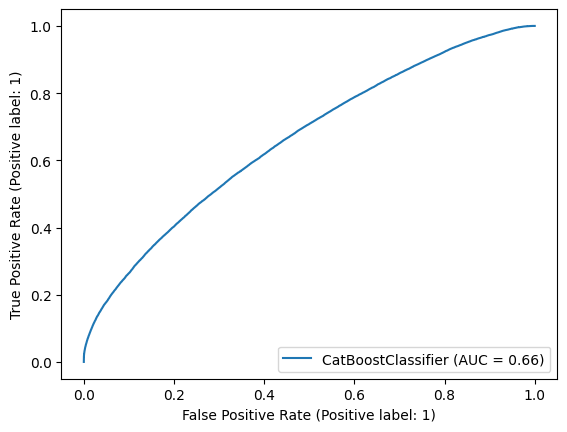

In [34]:
plot_roc_curve(cat, x, y)

Text(0.5, 1.0, 'Feature Importance')

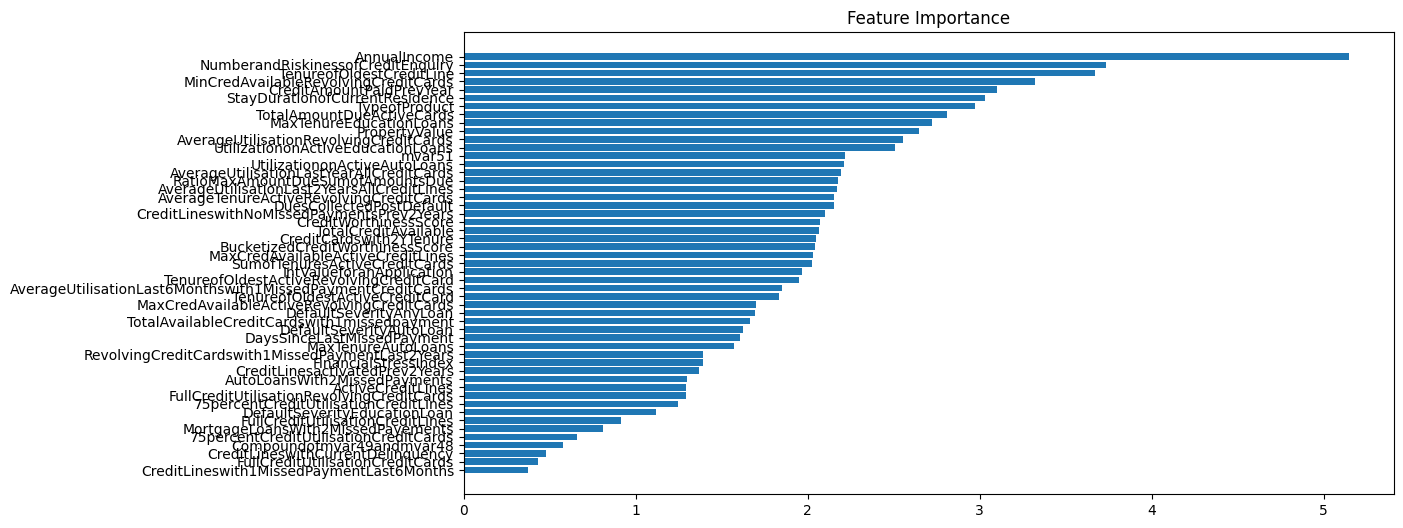

In [36]:
feature_importance = cat.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x.columns)[sorted_idx])
plt.title('Feature Importance')

### Final Training

In [24]:
train = df.iloc[:83000, :]

X_data = train.drop(['ID', 'default_ind'], axis = 1)
y_data = train['default_ind']

In [25]:
kfold = StratifiedKFold(random_state = 0, n_splits = 5, shuffle = True)
splits = kfold.split(X_data, y_data)

sm = SMOTE(random_state = 10, k_neighbors = 3, n_jobs = -1)

xgb_acc_scores = []
xgb_f1_scores = []
xgb_models = []

rf_acc_scores = []
rf_f1_scores = []
rf_models = []

for Train, Test in splits:
    X_Train, X_Test, Y_Train, Y_Test = X_data.iloc[Train], X_data.iloc[Test], y_data.iloc[Train], y_data.iloc[Test]
    
    xgb = XGBClassifier(n_estimators = 2000, max_depth = 8, n_jobs = -1, reg_lambda = 0.1,
                        learning_rate = 0.05, random_state = 0, early_stopping_rounds = 200)
    
    rf = RandomForestClassifier(n_estimators = 150, max_depth=8, n_jobs=-1, random_state=0)
    
    X_Train, Y_Train = sm.fit_resample(X_Train, Y_Train)
    
    xgb.fit(X_Train, Y_Train, eval_set = [(X_Train, Y_Train), (X_Test, Y_Test)], verbose = True)
    
    pred = xgb.predict(X_Test)
    
    xgb_f1_scores.append(f1_score(Y_Test, pred))
    xgb_acc_scores.append(accuracy_score(Y_Test, pred)*100)
    xgb_models.append(xgb)
    
    rf.fit(X_Train, Y_Train)
    
    pred = rf.predict(X_Test)
    
    rf_f1_scores.append(f1_score(Y_Test, pred))
    rf_acc_scores.append(accuracy_score(Y_Test, pred)*100)
    rf_models.append(rf)

[0]	validation_0-logloss:0.67264	validation_1-logloss:0.67860
[1]	validation_0-logloss:0.65399	validation_1-logloss:0.66530
[2]	validation_0-logloss:0.63711	validation_1-logloss:0.65294
[3]	validation_0-logloss:0.62119	validation_1-logloss:0.64177
[4]	validation_0-logloss:0.60687	validation_1-logloss:0.63150
[5]	validation_0-logloss:0.59341	validation_1-logloss:0.62225
[6]	validation_0-logloss:0.58085	validation_1-logloss:0.61361
[7]	validation_0-logloss:0.56897	validation_1-logloss:0.60546
[8]	validation_0-logloss:0.55778	validation_1-logloss:0.59792
[9]	validation_0-logloss:0.54785	validation_1-logloss:0.59133
[10]	validation_0-logloss:0.53822	validation_1-logloss:0.58508
[11]	validation_0-logloss:0.52918	validation_1-logloss:0.57909
[12]	validation_0-logloss:0.52066	validation_1-logloss:0.57370
[13]	validation_0-logloss:0.51260	validation_1-logloss:0.56866
[14]	validation_0-logloss:0.50510	validation_1-logloss:0.56385
[15]	validation_0-logloss:0.49748	validation_1-logloss:0.55929
[1

[130]	validation_0-logloss:0.31219	validation_1-logloss:0.48900
[131]	validation_0-logloss:0.31179	validation_1-logloss:0.48901
[132]	validation_0-logloss:0.31133	validation_1-logloss:0.48899
[133]	validation_0-logloss:0.31087	validation_1-logloss:0.48894
[134]	validation_0-logloss:0.31060	validation_1-logloss:0.48889
[135]	validation_0-logloss:0.31013	validation_1-logloss:0.48887
[136]	validation_0-logloss:0.30971	validation_1-logloss:0.48880
[137]	validation_0-logloss:0.30918	validation_1-logloss:0.48872
[138]	validation_0-logloss:0.30890	validation_1-logloss:0.48872
[139]	validation_0-logloss:0.30855	validation_1-logloss:0.48873
[140]	validation_0-logloss:0.30819	validation_1-logloss:0.48868
[141]	validation_0-logloss:0.30779	validation_1-logloss:0.48869
[142]	validation_0-logloss:0.30731	validation_1-logloss:0.48868
[143]	validation_0-logloss:0.30702	validation_1-logloss:0.48866
[144]	validation_0-logloss:0.30660	validation_1-logloss:0.48863
[145]	validation_0-logloss:0.30636	valid

[259]	validation_0-logloss:0.27681	validation_1-logloss:0.48920
[260]	validation_0-logloss:0.27670	validation_1-logloss:0.48920
[261]	validation_0-logloss:0.27647	validation_1-logloss:0.48922
[262]	validation_0-logloss:0.27633	validation_1-logloss:0.48920
[263]	validation_0-logloss:0.27620	validation_1-logloss:0.48922
[264]	validation_0-logloss:0.27587	validation_1-logloss:0.48920
[265]	validation_0-logloss:0.27581	validation_1-logloss:0.48919
[266]	validation_0-logloss:0.27554	validation_1-logloss:0.48920
[267]	validation_0-logloss:0.27520	validation_1-logloss:0.48926
[268]	validation_0-logloss:0.27511	validation_1-logloss:0.48927
[269]	validation_0-logloss:0.27471	validation_1-logloss:0.48936
[270]	validation_0-logloss:0.27439	validation_1-logloss:0.48937
[271]	validation_0-logloss:0.27424	validation_1-logloss:0.48939
[272]	validation_0-logloss:0.27394	validation_1-logloss:0.48942
[273]	validation_0-logloss:0.27377	validation_1-logloss:0.48942
[274]	validation_0-logloss:0.27337	valid

[2]	validation_0-logloss:0.63725	validation_1-logloss:0.65301
[3]	validation_0-logloss:0.62192	validation_1-logloss:0.64200
[4]	validation_0-logloss:0.60743	validation_1-logloss:0.63155
[5]	validation_0-logloss:0.59399	validation_1-logloss:0.62213
[6]	validation_0-logloss:0.58165	validation_1-logloss:0.61326
[7]	validation_0-logloss:0.56998	validation_1-logloss:0.60518
[8]	validation_0-logloss:0.55933	validation_1-logloss:0.59772
[9]	validation_0-logloss:0.54933	validation_1-logloss:0.59093
[10]	validation_0-logloss:0.54003	validation_1-logloss:0.58463
[11]	validation_0-logloss:0.53086	validation_1-logloss:0.57875
[12]	validation_0-logloss:0.52233	validation_1-logloss:0.57308
[13]	validation_0-logloss:0.51471	validation_1-logloss:0.56818
[14]	validation_0-logloss:0.50693	validation_1-logloss:0.56312
[15]	validation_0-logloss:0.50010	validation_1-logloss:0.55892
[16]	validation_0-logloss:0.49327	validation_1-logloss:0.55457
[17]	validation_0-logloss:0.48681	validation_1-logloss:0.55068


[132]	validation_0-logloss:0.31460	validation_1-logloss:0.48227
[133]	validation_0-logloss:0.31404	validation_1-logloss:0.48223
[134]	validation_0-logloss:0.31360	validation_1-logloss:0.48222
[135]	validation_0-logloss:0.31318	validation_1-logloss:0.48220
[136]	validation_0-logloss:0.31275	validation_1-logloss:0.48218
[137]	validation_0-logloss:0.31225	validation_1-logloss:0.48212
[138]	validation_0-logloss:0.31186	validation_1-logloss:0.48214
[139]	validation_0-logloss:0.31155	validation_1-logloss:0.48210
[140]	validation_0-logloss:0.31132	validation_1-logloss:0.48207
[141]	validation_0-logloss:0.31094	validation_1-logloss:0.48204
[142]	validation_0-logloss:0.31058	validation_1-logloss:0.48208
[143]	validation_0-logloss:0.31035	validation_1-logloss:0.48209
[144]	validation_0-logloss:0.30996	validation_1-logloss:0.48209
[145]	validation_0-logloss:0.30957	validation_1-logloss:0.48209
[146]	validation_0-logloss:0.30912	validation_1-logloss:0.48212
[147]	validation_0-logloss:0.30885	valid

[261]	validation_0-logloss:0.28002	validation_1-logloss:0.48212
[262]	validation_0-logloss:0.27979	validation_1-logloss:0.48212
[263]	validation_0-logloss:0.27962	validation_1-logloss:0.48208
[264]	validation_0-logloss:0.27951	validation_1-logloss:0.48210
[265]	validation_0-logloss:0.27927	validation_1-logloss:0.48211
[266]	validation_0-logloss:0.27892	validation_1-logloss:0.48207
[267]	validation_0-logloss:0.27877	validation_1-logloss:0.48209
[268]	validation_0-logloss:0.27865	validation_1-logloss:0.48213
[269]	validation_0-logloss:0.27832	validation_1-logloss:0.48218
[270]	validation_0-logloss:0.27828	validation_1-logloss:0.48220
[271]	validation_0-logloss:0.27805	validation_1-logloss:0.48220
[272]	validation_0-logloss:0.27769	validation_1-logloss:0.48219
[273]	validation_0-logloss:0.27738	validation_1-logloss:0.48215
[274]	validation_0-logloss:0.27730	validation_1-logloss:0.48213
[275]	validation_0-logloss:0.27721	validation_1-logloss:0.48218
[276]	validation_0-logloss:0.27699	valid

[1]	validation_0-logloss:0.65356	validation_1-logloss:0.66535
[2]	validation_0-logloss:0.63648	validation_1-logloss:0.65330
[3]	validation_0-logloss:0.62025	validation_1-logloss:0.64249
[4]	validation_0-logloss:0.60562	validation_1-logloss:0.63239
[5]	validation_0-logloss:0.59218	validation_1-logloss:0.62326
[6]	validation_0-logloss:0.57947	validation_1-logloss:0.61470
[7]	validation_0-logloss:0.56783	validation_1-logloss:0.60699
[8]	validation_0-logloss:0.55691	validation_1-logloss:0.60003
[9]	validation_0-logloss:0.54658	validation_1-logloss:0.59334
[10]	validation_0-logloss:0.53668	validation_1-logloss:0.58723
[11]	validation_0-logloss:0.52785	validation_1-logloss:0.58167
[12]	validation_0-logloss:0.51945	validation_1-logloss:0.57670
[13]	validation_0-logloss:0.51154	validation_1-logloss:0.57204
[14]	validation_0-logloss:0.50424	validation_1-logloss:0.56760
[15]	validation_0-logloss:0.49728	validation_1-logloss:0.56353
[16]	validation_0-logloss:0.49055	validation_1-logloss:0.55954
[

[131]	validation_0-logloss:0.31192	validation_1-logloss:0.49565
[132]	validation_0-logloss:0.31176	validation_1-logloss:0.49559
[133]	validation_0-logloss:0.31117	validation_1-logloss:0.49559
[134]	validation_0-logloss:0.31082	validation_1-logloss:0.49553
[135]	validation_0-logloss:0.31060	validation_1-logloss:0.49555
[136]	validation_0-logloss:0.31017	validation_1-logloss:0.49555
[137]	validation_0-logloss:0.30973	validation_1-logloss:0.49552
[138]	validation_0-logloss:0.30956	validation_1-logloss:0.49554
[139]	validation_0-logloss:0.30915	validation_1-logloss:0.49546
[140]	validation_0-logloss:0.30900	validation_1-logloss:0.49549
[141]	validation_0-logloss:0.30856	validation_1-logloss:0.49547
[142]	validation_0-logloss:0.30802	validation_1-logloss:0.49551
[143]	validation_0-logloss:0.30765	validation_1-logloss:0.49552
[144]	validation_0-logloss:0.30724	validation_1-logloss:0.49548
[145]	validation_0-logloss:0.30702	validation_1-logloss:0.49549
[146]	validation_0-logloss:0.30677	valid

[48]	validation_0-logloss:0.38065	validation_1-logloss:0.50154
[49]	validation_0-logloss:0.37867	validation_1-logloss:0.50090
[50]	validation_0-logloss:0.37682	validation_1-logloss:0.50024
[51]	validation_0-logloss:0.37520	validation_1-logloss:0.49970
[52]	validation_0-logloss:0.37330	validation_1-logloss:0.49912
[53]	validation_0-logloss:0.37168	validation_1-logloss:0.49857
[54]	validation_0-logloss:0.37006	validation_1-logloss:0.49805
[55]	validation_0-logloss:0.36859	validation_1-logloss:0.49760
[56]	validation_0-logloss:0.36713	validation_1-logloss:0.49706
[57]	validation_0-logloss:0.36580	validation_1-logloss:0.49668
[58]	validation_0-logloss:0.36449	validation_1-logloss:0.49631
[59]	validation_0-logloss:0.36330	validation_1-logloss:0.49598
[60]	validation_0-logloss:0.36196	validation_1-logloss:0.49565
[61]	validation_0-logloss:0.36095	validation_1-logloss:0.49534
[62]	validation_0-logloss:0.35973	validation_1-logloss:0.49504
[63]	validation_0-logloss:0.35849	validation_1-logloss:

[177]	validation_0-logloss:0.29995	validation_1-logloss:0.48669
[178]	validation_0-logloss:0.29981	validation_1-logloss:0.48670
[179]	validation_0-logloss:0.29962	validation_1-logloss:0.48669
[180]	validation_0-logloss:0.29931	validation_1-logloss:0.48666
[181]	validation_0-logloss:0.29897	validation_1-logloss:0.48670
[182]	validation_0-logloss:0.29855	validation_1-logloss:0.48673
[183]	validation_0-logloss:0.29846	validation_1-logloss:0.48671
[184]	validation_0-logloss:0.29828	validation_1-logloss:0.48671
[185]	validation_0-logloss:0.29804	validation_1-logloss:0.48668
[186]	validation_0-logloss:0.29777	validation_1-logloss:0.48667
[187]	validation_0-logloss:0.29765	validation_1-logloss:0.48667
[188]	validation_0-logloss:0.29741	validation_1-logloss:0.48663
[189]	validation_0-logloss:0.29721	validation_1-logloss:0.48661
[190]	validation_0-logloss:0.29696	validation_1-logloss:0.48658
[191]	validation_0-logloss:0.29668	validation_1-logloss:0.48660
[192]	validation_0-logloss:0.29640	valid

[306]	validation_0-logloss:0.26897	validation_1-logloss:0.48755
[307]	validation_0-logloss:0.26889	validation_1-logloss:0.48757
[308]	validation_0-logloss:0.26852	validation_1-logloss:0.48762
[309]	validation_0-logloss:0.26835	validation_1-logloss:0.48767
[310]	validation_0-logloss:0.26822	validation_1-logloss:0.48767
[311]	validation_0-logloss:0.26789	validation_1-logloss:0.48767
[312]	validation_0-logloss:0.26766	validation_1-logloss:0.48764
[313]	validation_0-logloss:0.26758	validation_1-logloss:0.48767
[314]	validation_0-logloss:0.26736	validation_1-logloss:0.48771
[315]	validation_0-logloss:0.26714	validation_1-logloss:0.48771
[316]	validation_0-logloss:0.26683	validation_1-logloss:0.48777
[317]	validation_0-logloss:0.26667	validation_1-logloss:0.48781
[318]	validation_0-logloss:0.26642	validation_1-logloss:0.48786
[319]	validation_0-logloss:0.26632	validation_1-logloss:0.48788
[320]	validation_0-logloss:0.26609	validation_1-logloss:0.48793
[321]	validation_0-logloss:0.26583	valid

[39]	validation_0-logloss:0.39742	validation_1-logloss:0.51112
[40]	validation_0-logloss:0.39529	validation_1-logloss:0.51029
[41]	validation_0-logloss:0.39285	validation_1-logloss:0.50943
[42]	validation_0-logloss:0.39042	validation_1-logloss:0.50859
[43]	validation_0-logloss:0.38812	validation_1-logloss:0.50775
[44]	validation_0-logloss:0.38584	validation_1-logloss:0.50696
[45]	validation_0-logloss:0.38409	validation_1-logloss:0.50624
[46]	validation_0-logloss:0.38209	validation_1-logloss:0.50562
[47]	validation_0-logloss:0.37992	validation_1-logloss:0.50496
[48]	validation_0-logloss:0.37795	validation_1-logloss:0.50433
[49]	validation_0-logloss:0.37603	validation_1-logloss:0.50372
[50]	validation_0-logloss:0.37423	validation_1-logloss:0.50316
[51]	validation_0-logloss:0.37260	validation_1-logloss:0.50272
[52]	validation_0-logloss:0.37100	validation_1-logloss:0.50220
[53]	validation_0-logloss:0.36934	validation_1-logloss:0.50182
[54]	validation_0-logloss:0.36777	validation_1-logloss:

[296]	validation_0-logloss:0.27033	validation_1-logloss:0.49343
[297]	validation_0-logloss:0.26994	validation_1-logloss:0.49345
[298]	validation_0-logloss:0.26955	validation_1-logloss:0.49355
[299]	validation_0-logloss:0.26943	validation_1-logloss:0.49350
[300]	validation_0-logloss:0.26934	validation_1-logloss:0.49346
[301]	validation_0-logloss:0.26918	validation_1-logloss:0.49350
[302]	validation_0-logloss:0.26889	validation_1-logloss:0.49347
[303]	validation_0-logloss:0.26879	validation_1-logloss:0.49345
[304]	validation_0-logloss:0.26844	validation_1-logloss:0.49350
[305]	validation_0-logloss:0.26840	validation_1-logloss:0.49350
[306]	validation_0-logloss:0.26834	validation_1-logloss:0.49347
[307]	validation_0-logloss:0.26809	validation_1-logloss:0.49348
[308]	validation_0-logloss:0.26802	validation_1-logloss:0.49347
[309]	validation_0-logloss:0.26796	validation_1-logloss:0.49350
[310]	validation_0-logloss:0.26764	validation_1-logloss:0.49358
[311]	validation_0-logloss:0.26747	valid

In [26]:
print("XGB F1 Score: ", sum(xgb_f1_scores)/len(xgb_f1_scores))
print("XGB Accuracy: ", sum(xgb_acc_scores)/len(xgb_acc_scores), "%")
print("RF F1 Score: ", sum(rf_f1_scores)/len(rf_f1_scores))
print("RF Accuracy: ", sum(rf_acc_scores)/len(rf_acc_scores), "%")

XGB F1 Score:  0.5208489323124416
XGB Accuracy:  76.7590361445783 %
RF F1 Score:  0.5665445367150396
RF Accuracy:  74.49397590361446 %


<Figure size 1000x1000 with 0 Axes>

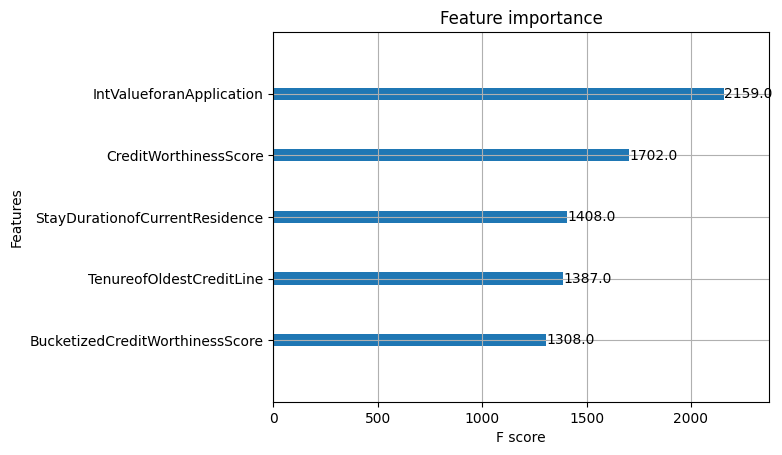

In [27]:
model = xgb_models[0]

plt.figure(figsize = (10,10))
plot_importance(model, max_num_features = 5)
plt.show()

In [20]:
test = df.iloc[83000:, :]
test = test.drop(['ID', 'default_ind'], axis = 1)

In [29]:
preds = np.argmax(#xgb_models[0].predict_proba(test) +
                  #xgb_models[1].predict_proba(test) +
                  #xgb_models[2].predict_proba(test) +
                  #xgb_models[3].predict_proba(test) +
                  #xgb_models[4].predict_proba(test) +
                  rf_models[0].predict_proba(test) +
                  rf_models[1].predict_proba(test) +
                  rf_models[2].predict_proba(test) +
                  rf_models[3].predict_proba(test) +
                  rf_models[4].predict_proba(test), axis = 1)

In [30]:
sample = pd.read_csv('submission.csv', header = None)
sample.head()

,0,1
0,578069,0
1,578070,1
2,578071,1
3,578072,1
4,578073,0


In [31]:
sample[1] = preds
sample.head()

,0,1
0,578069,0
1,578070,0
2,578071,0
3,578072,1
4,578073,0


In [32]:
sample[1].value_counts()

0    31972
1    15028
Name: 1, dtype: int64

In [33]:
#sample.to_csv('Submissions/ThirdDegreeBurn_3.csv', index = False, header=False)